In [2]:
import sys
sys.path.append("..")
import Platform.testpython_custom as ximc
import numpy as np
import serial, time
import matplotlib.pyplot as plt
from IPython import display
from datetime import timedelta
from mpl_toolkits.mplot3d import Axes3D
import csv

Library loaded
Library version: 2.10.5


## Открываем доступ к контроллеру Standa

In [86]:
lib, dev_id = ximc.open_device('Mirror Axis 1', 'Mirror Axis 2')

Device enum handle: <pyximc.LP_device_enumeration_t object at 0x000001ED07DDB548>
Device enum handle type: <class 'pyximc.LP_device_enumeration_t'>
Device count: 0

Some devices failed to open


In [70]:
Mirror_axis_v, Mirror_axis_h = dev_id[0], dev_id[1]
# print(ximc.test_get_position(lib, Mirror_axis_h), ximc.test_get_position(lib, Mirror_axis_v))
# (-5815, -223) (1257, 24) НАЧАЛО
# -5812.0 1253.0 ОК
ximc.test_move(lib, Mirror_axis_h, -5812, 0)
ximc.test_move(lib, Mirror_axis_v, 1253, 0)
print(ximc.test_get_position(lib, Mirror_axis_h), ximc.test_get_position(lib, Mirror_axis_v))


Going to -5812 steps, 0 microsteps
Result: 0

Going to 1253 steps, 0 microsteps
Result: 0

Read position
Result: 0
Position: -5815 steps, -223 microsteps

Read position
Result: 0
Position: 1257 steps, 24 microsteps
(-5815, -223) (1257, 24)


## Задаем индивидуальные номера девайсов и задаем начальное положение контроллеров

In [6]:
Mirror_axis_v, Mirror_axis_h = dev_id[0], dev_id[1]
MAH_steps_0, MAH_microsteps_0 = ximc.test_get_position(lib, Mirror_axis_h)[0], ximc.test_get_position(lib, Mirror_axis_h)[1]
MAV_steps_0, MAV_microsteps_0 = ximc.test_get_position(lib, Mirror_axis_v)[0], ximc.test_get_position(lib, Mirror_axis_v)[1]


Read position
Result: 0
Position: -5815 steps, -223 microsteps

Read position
Result: 0
Position: -5815 steps, -223 microsteps

Read position
Result: 0
Position: 1257 steps, 24 microsteps

Read position
Result: 0
Position: 1257 steps, 24 microsteps


## Выводим контроллер в начальное положение с максимальным количеством совпадений 

In [5]:
# ximc.test_move(lib, Mirror_axis_h, MAH_steps_0 , MAH_microsteps_0) #увеличение ведет влево, если смотреть лицом
# ximc.test_move(lib, Mirror_axis_v, MAV_steps_0 , MAV_microsteps_0) #увеличение ведет вниз

## Открываем порт для приема данных с Arduino

In [72]:
try:
    s = serial.Serial('COM25',115200)
except IOError: 
    pass

print(s)

Serial<id=0x1ed085a9780, open=True>(port='COM25', baudrate=115200, bytesize=8, parity='N', stopbits=1, timeout=None, xonxoff=False, rtscts=False, dsrdtr=False)


## Очищаем буфер порта и передаем команду на построчное считывания, затем снова очищаем буфер

In [8]:
s.reset_input_buffer()
s.readline()
s.reset_input_buffer()

## Основной код программы.
В этом разделе объявляются четыре массива. В первых трех массивах записываются показания детекторов и схемы совпадений, а четвертый массив думерный отвечает пространственному распределению положения луча. 
Первый цикл отвечает за смещение по горизонтали, затем внутри цикла реализуется система прохода змейкой вниз, вверх, вниз и тд.
Затем в реальном времени строится трехмерный график распределения совпадений

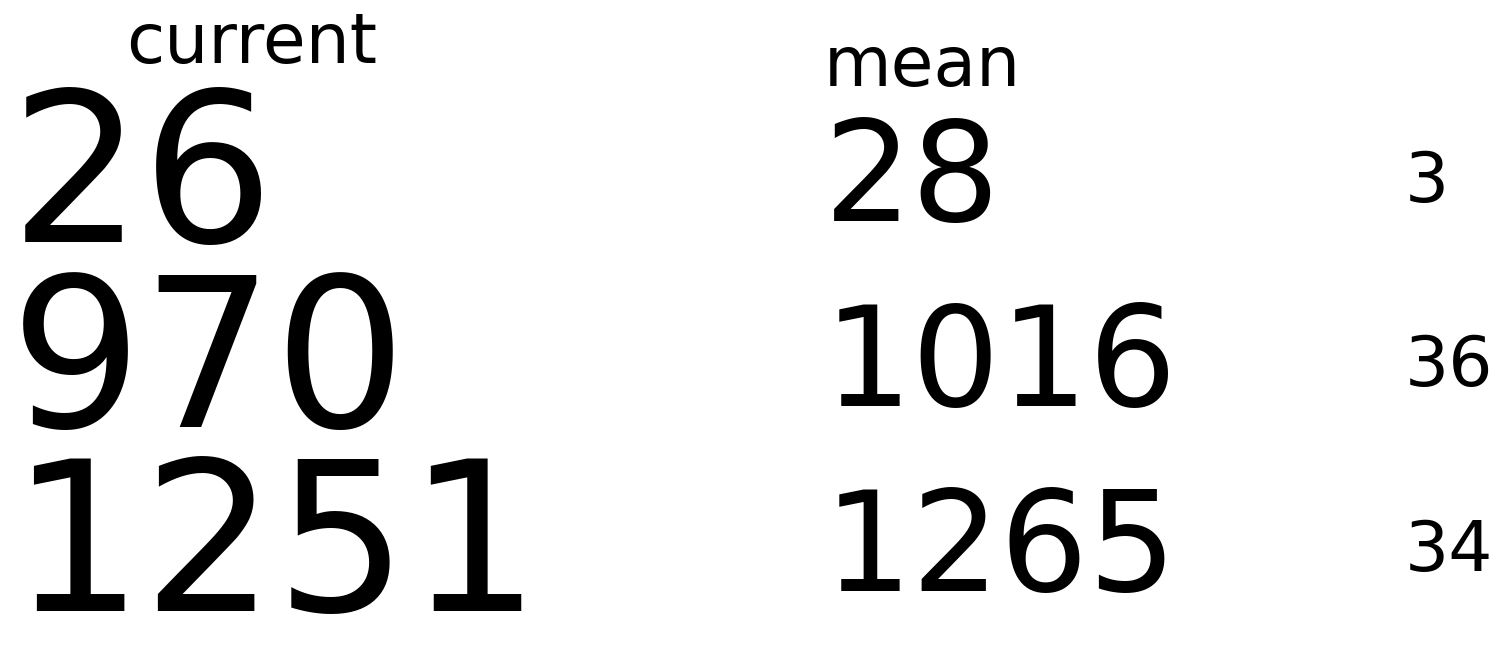

'17:23:53'

971.3444390296936

Going to -5815 steps, -223 microsteps
Result: 0

Going to 1257 steps, 24 microsteps
Result: 0


In [73]:
size = 10
l = 1
steps = size // 2 
length = 5
mas_sum_1 = np.zeros((size // l + 1 , size // l + 1)) # отражение
mas_sum_2 = np.zeros((size // l + 1 , size // l + 1 )) # пропускание
mas_sum_3 = np.zeros((size // l + 1 , size // l + 1)) # cовпадения
vertical = np.zeros((size // l + 1  , size // l + 1 ))
horizontal = np.zeros((size // l + 1 , size // l + 1 ))
a  = 0
t0 = time.time()
for i in range(-steps, steps + 1, l): # проход по горизонтали
    b = 0
    for j in range(-steps, steps + 1, l):
        print(i, j)
        ximc.test_move(lib, Mirror_axis_h, MAH_steps_0 + i, MAH_microsteps_0)
        ximc.test_move(lib, Mirror_axis_v, MAV_steps_0 + j, MAV_microsteps_0)
        vertical[a][b] = MAV_steps_0 + j
        horizontal[a][b] = MAH_steps_0 + i
        time.sleep(1)
        display.clear_output(wait = True)
        readings = [[],[],[]]
        t1 = time.time()
        s.reset_input_buffer()
        s.readline()
        s.reset_input_buffer()
        t2 = time.time() 
        while  len(readings[1]) <= length:
            raw_reading = s.readline().decode(errors='ignore')
            reading = [int(part.strip()) for part in raw_reading.split('\t')] 
            for k in range(3):
                readings[k].append(reading[k])
        t3 = time.time()        
        mas_sum_1[a][b] = int(np.mean(readings[0][-length:]))
        mas_sum_2[a][b] = int(np.mean(readings[1][-length:]))
        mas_sum_3[a][b] = int(np.mean(readings[2][-length:]))
        print(mas_sum_3[a][b], t3 - t1, t3 - t2)
        b += 1
        display.clear_output(wait=True)
        f, ax = plt.subplots(figsize=(15,0.3))
        ax.axis("off")
        ax.text(0.05, 25, 'current', transform=ax.transAxes, fontsize=50,
            verticalalignment='bottom')
        ax.text(0.65, 24, 'mean', transform=ax.transAxes, fontsize=50,
            verticalalignment='bottom')
        ax.text(-0.05, 0, reading[0], transform=ax.transAxes, fontsize=150,
            verticalalignment='bottom')
        ax.text(-0.05, 8, reading[1], transform=ax.transAxes, fontsize=150,
            verticalalignment='bottom')
        ax.text(-0.05, 16, reading[2], transform=ax.transAxes, fontsize=150,
            verticalalignment='bottom')
        ax.text(0.65, 1.5, int(np.mean(readings[0][-10:])), transform=ax.transAxes, fontsize=100,
            verticalalignment='bottom')
        ax.text(0.65, 9.5, int(np.mean(readings[1][-10:])), transform=ax.transAxes, fontsize=100,
            verticalalignment='bottom')
        ax.text(0.65, 17.5, int(np.mean(readings[2][-10:])), transform=ax.transAxes, fontsize=100,
            verticalalignment='bottom')
        ax.text(1.15, 3, int(np.std(readings[0][-10:])), transform=ax.transAxes, fontsize=50, 
            verticalalignment='bottom')
        ax.text(1.15, 11, int(np.std(readings[1][-10:])), transform=ax.transAxes, fontsize=50,
            verticalalignment='bottom')
        ax.text(1.15, 19, int(np.std(readings[2][-10:])), transform=ax.transAxes, fontsize=50,
            verticalalignment='bottom')
        plt.show()
        display.display(time.strftime('%H:%M:%S'))
    a += 1
    

#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     x = horizontal [:a + 1]
#     y = vertical[:a + 1]
#     z = mas_sum_1[:a + 1]
#     ax.scatter(x, y, z)
#     ax.plot_surface(x, y, z, cmap='inferno')

# fig = plt.figure(figsize = (10,10))
# ax = fig.add_subplot(111, projection='3d')
# x = horizontal
# y = vertical
# z = mas_sum_3
# ax.scatter(x, y, z)
# ax.plot_surface(x, y, z, cmap='inferno')
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#x = horizontal [:a + 1]
#y = vertical[:a + 1]
#z = mas_sum_1[:a + 1]
#ax.scatter(x, y, z)
# np.save('Exp Data\\' + "%s_mas_sum1"%time.strftime('%Y-%m-%d_%H-%M'), mas_sum_1)
# np.save('Exp Data\\'+"%s_mas_sum2"%time.strftime('%Y-%m-%d_%H-%M'), mas_sum_2)
# np.save('Exp Data\\'+"%s_mas_sum3"%time.strftime('%Y-%m-%d_%H-%M'), mas_sum_3)
# np.save('Exp Data\\'+"%s_vertical"%time.strftime('%Y-%m-%d_%H-%M'), vertical)
# np.save('Exp Data\\'+"%s_horizontal"%time.strftime('%Y-%m-%d_%H-%M'), horizontal)
# fig.savefig("Exp Data\\" +"%s_plot.png"%time.strftime('%Y-%m-%d_%H-%M'))

print(time.time() - t0) 
ximc.test_move(lib, Mirror_axis_h, MAH_steps_0 , MAH_microsteps_0) 
ximc.test_move(lib, Mirror_axis_v, MAV_steps_0 , MAV_microsteps_0)

In [10]:
mas_sum_1

array([[2624., 2440., 2348., 2424., 2379., 2449., 2816., 2836., 2588.,
        2498., 2338.],
       [2365., 2427., 2505., 2495., 2487., 2646., 2753., 2444., 2380.,
        2722., 2623.],
       [2555., 2741., 2762., 2730., 2712., 2662., 2640., 2616., 2642.,
        2655., 2645.],
       [2661., 2618., 2670., 2709., 2642., 2477., 2249., 2385., 2575.,
        2612., 2598.],
       [2582., 2529., 2528., 2487., 2384., 2555., 2591., 2471., 2502.,
        2348., 2383.],
       [2325., 2396., 2315., 2070., 2201., 2237., 2215., 2150., 2057.,
        2168., 2357.],
       [2523., 2469., 2487., 2432., 2380., 2428., 2417., 2192., 2080.,
        2280., 2398.],
       [2382., 2387., 2404., 2349., 2392., 2354., 2434., 2416., 2409.,
        2397., 2387.],
       [2395., 2369., 2345., 2366., 2406., 2338., 2353., 2357., 2332.,
        2363., 2325.],
       [2322., 2305., 2312., 2326., 2300., 2290., 2281., 2293., 2278.,
        2267., 2258.],
       [2244., 2265., 2242., 2259., 2222., 2266., 2250., 219

In [74]:
import pandas 
from datetime import datetime

columns = ["mas_sum_1", "mas_sum_2", "mas_sum_3", "horizontal", "vertical"]
now = datetime.now()

data = pandas.DataFrame(list(zip(mas_sum_1, mas_sum_2, mas_sum_3, horizontal, vertical)), columns=columns)
data.to_csv("result_01_02.csv", index=False)

## Возвращение на первоначальную позицию

In [103]:
ximc.test_move(lib, Mirror_axis_h, MAH_steps_0 , MAH_microsteps_0) 
ximc.test_move(lib, Mirror_axis_v, MAV_steps_0 , MAV_microsteps_0)


Going to -5815 steps, -223 microsteps
Result: 0

Going to 1257 steps, 24 microsteps
Result: 0


## Закрываем ком порт и доступ к контроллеру

In [12]:
ximc.close_device(lib, dev_id)


Closing


ArgumentError: argument 1: <class 'TypeError'>: wrong type

In [84]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111)
x = horizontal
y = vertical
z = mas_sum_3
# ax.scatter(x, y, z, 'r')
# ax.plot(x, y, z)
# plt.show()
# (-5815, -223)
# plt.imshow(z)
# print(np.where(z == 57.))
print(z[2][7])
print(x[2][7])
print(y[2][7])
# print(np.max(z))

# print(x, y, z)

# -5812.0 1253.0 ОК

57.0
-5818.0
1259.0


In [85]:
s.close()

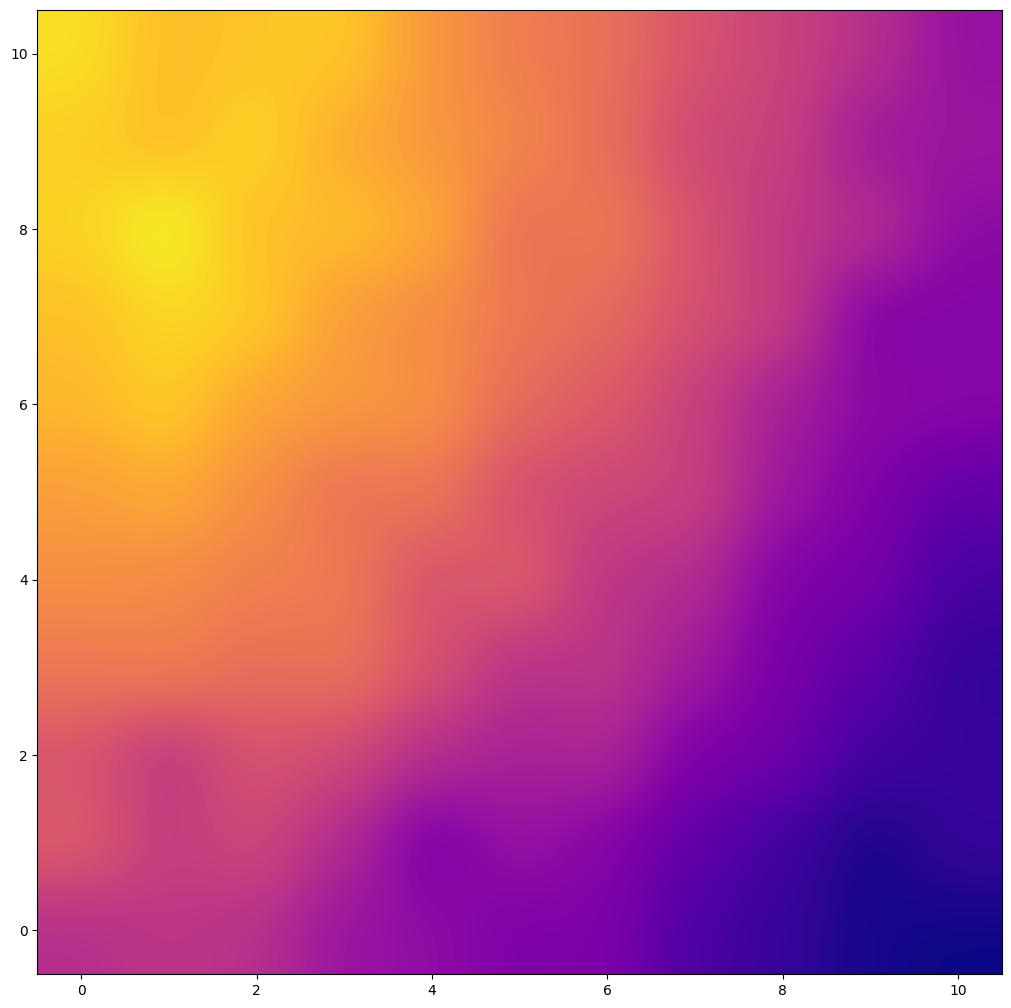

In [46]:
# fig = plt.figure(figsize = (10,10))
# ax = fig.add_subplot(111, projection='3d')
# x = horizontal
# y = vertical
# z = mas_sum_3
# ax.scatter(x, y, z)
# plt.title('mas_sum_3')
# fig = plt.figure(figsize = (10,10))
# ax = fig.add_subplot(111, projection='3d')
x = horizontal
y = vertical
z = mas_sum_3
# print(x, y, z)
# print(len(x[:11]), len(y[:11]), len(z))
# ax.scatter(x, y, z)
# ax.plot_surface(x, y, z, cmap='inferno')
fig = plt.figure(figsize = (10,10), constrained_layout=True)
# plt.imshow(mas_sum_3, cmap='plasma', aspect='equal', interpolation='gaussian', origin="lower", extent=(2037, 2051, -5865, -5851))
# fig.colorbar(p2)
plt.imshow(mas_sum_3, cmap='plasma', aspect='equal', 
           interpolation='gaussian', origin="lower")
plt.show()

In [88]:
ximc.test_move(lib, Mirror_axis_h, -5815, 50)
ximc.test_move(lib, Mirror_axis_v, 1257, 0)

# -5812.0 1253.0 ОК


Going to -5815 steps, 50 microsteps
Result: 0

Going to 1257 steps, 0 microsteps
Result: 0


In [27]:
s.close()


In [94]:
 # -5821 1261
# ximc.test_move(lib, Mirror_axis_v, 1261, 0)
    
print(ximc.test_get_position(lib, Mirror_axis_h), ximc.test_get_position(lib, Mirror_axis_v))


Read position
Result: 0
Position: -5821 steps, -206 microsteps

Read position
Result: 0
Position: 1262 steps, 0 microsteps
(-5821, -206) (1262, 0)
